## BENCHMARKING PWMs and SVMs for TFBS PREDICTION: DENSITYPLOT

In [243]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import mannwhitneyu
import re
from dataclasses import dataclass
from dataclasses import field

In [263]:
@dataclass
class DensityplotArgs():
    dpi: int = 300
    titlesize: int = 20
    labelsize: int = 15
    xlim: tuple = (0, 1)
    ylim: tuple = (0, 50)
    lengths: tuple = ('est_lmer', 'wgkm', 'wgkmrbf')
    optimal: bool = False
    tools: tuple = ("meme", "streme","svm")
    analysis: str = "k" # "sw", "k"
    metrics: tuple = ("AUPRC", "AUROC")
    background: str = "shuffle"
    data_dir: str = f"Data_{background.upper()}/svm-kernel-comparison"
    output_dir: str = "outputdir"
    formats: tuple = ("svg")
    colors: dict = field(default_factory = lambda: {"ds": ["#f7b32bff", "#d52a39ff", "#366fdaff"], "k": {
            'est_lmer': "#6d4b4bff",
            'gapped_kmer': '#599e94ff',
            'gkm': '#333333ff',
            'gkmrbf': '#466964ff',
            'wgkm': '#e27c7cff',
            'wgkmrbf': '#a86464ff'
        }, "sw": ["#f7b32bff", "#f7b32bff", "#d52a39ff", "#d52a39ff", "#366fdaff", "#366fdaff"]})

In [264]:
tools = ["meme", "streme", "svm"]
TOOLS = ["MEME", "STREME", "LS-GKM"]
KERNELS = ['est_lmer', 'gapped_kmer', 'gkm', 'gkmrbf', 'wgkm', 'wgkmrbf']
sw_cases = ["full", "optimal"]

def extract_kernel(name):
    splits = name.split("_")
    if len(splits) == 4:
        return splits[-1]
    else:
        return f"{splits[-2]}_{splits[-1]}"


def args_ds(length, background = None, metric = None, output_dir = None):
    """
    Take input length and metric and return utils for ds analysis
    """
    input_filename = f"summary_table_size_{length}.tsv"
    
    if metric == None:
        return input_filename
    
    cols = [f"{metric}_{tool}_size_{length}" for tool in tools]
    size = "full_size" if length == '0' else f"size_{length}"
    legend_bar = [f"{metric}_{tool}_{size}" for tool in TOOLS]
    output_base = f"{output_dir}/DensityPlot_{size}_{background}_{metric}"

    return cols, legend_bar, output_base

def args_sw(width, background = None, metric = None, output_dir = None):
    """
    Take input length and metric and return utils for sw analysis
    """

    
    input_filenames = [f"summary_table_{optimal}_width_{width}.tsv" for optimal in sw_cases]
    
    if metric == None:
        return input_filenames
    
    cols = [f"{metric}_{tool}_{optimal}_width_{width}" for tool in tools for optimal in sw_cases]
    size = "full_width" if width == '0' else f"width_{width}"
    legend_bar = [f"{metric}_{optimal}_{tool}_{size}" for tool in TOOLS for optimal in sw_cases]
    output_base = f"{output_dir}/DensityPlot_{width}_{background}_{metric}"

    return cols, legend_bar, output_base

def args_k(kernel, optimal, args: DensityplotArgs, background = None, metric = None, output_dir = None):
    """
    Take input length and metric and return utils for k analysis
    """
    optimal = "optimal" if optimal else "full"
    input_filename = f"summary_table_{optimal}_{kernel}.tsv"

    if metric == None:
        return input_filename

    cols = [f"{metric}_svm_{optimal}_{k}" for k in args.lengths]
    optimal = "optimal" if optimal else "full"
    legend_bar = [f"{metric}_LS-GKM_{kernel}" for kernel in args.lengths]
    output_base = f"{output_dir}/DensityPlot_kernel_{optimal}_{background}_{metric}"

    return cols, legend_bar, output_base

In [265]:
def create_densityplot_sw(df, cols, args):
    fig = plt.figure()
    ax = fig.gca()
    for i, col in enumerate(cols):
        if i % 2 == 0: # full cols are in even positions
            sns.kdeplot(df[col], ax=ax, linestyle="-", color=args.colors[args.analysis][i])
        else:
            sns.kdeplot(df[col], ax=ax, linestyle="--", color = args.colors[args.analysis][i])
    return ax

def create_densityplot_ds(df, cols, args):
    fig = plt.figure()
    ax = fig.gca()
    for i, col in enumerate(cols):
        sns.kdeplot(df[col], ax = ax, color = args.colors[args.analysis][i])
    return ax

def create_densityplot_k(df, cols, args):
    fig = plt.figure()
    ax = fig.gca()
    for i, col in enumerate(cols):
        kernel = extract_kernel(col)
        sns.kdeplot(df[col], ax = ax, color = args.colors[args.analysis][kernel])
    return ax
     

In [266]:
def retrieve_densityplot_data(args: DensityplotArgs, length):
 
    if args.analysis == "sw":
        input_filenames = args_sw(length)
        df_opt = pd.read_csv(os.path.join(args.data_dir, input_filenames[0]), sep = "\t")
        df_full = pd.read_csv(os.path.join(args.data_dir, input_filenames[1]), sep = "\t")
        df = pd.concat([df_opt, df_full], axis=0, join='outer')
        
    elif args.analysis == "ds":
        input_filename = args_ds(length)
        df = pd.read_csv(os.path.join(args.data_dir,input_filename), sep = '\t')
        
    elif args.analysis == "k":
        for kernel in args.lengths:
            input_filename = args_k(kernel, args.optimal, args)
            df_kernel = pd.read_csv(os.path.join(args.data_dir, input_filename), sep = "\t")
            try:
                df = pd.concat([df, df_kernel], axis = 0, join = "outer")
            except:
                df = df_kernel

    else:
        raise ValueError("analysis must be one of the following ['sw', 'ds', 'k']")
    
    return df


def create_densityplot(df, length, metric, args: DensityplotArgs):

    plt.figure(args.dpi)

    # Take cols, create legend and output name based on analysis
    if args.analysis == "sw":
        cols, legend_plot, output_base = args_sw(length, args.background, metric, args.output_dir)
        ax = create_densityplot_sw(df, cols, args)
    elif args.analysis == "ds":
        cols, legend_plot, output_base = args_ds(length, args.background, metric, args.output_dir)
        ax = create_densityplot_ds(df, cols, args)
    elif args.analysis == "k":
        cols, legend_plot, output_base = args_k(length, args.optimal, args, args.background, metric, args.output_dir)
        ax = create_densityplot_k(df, cols, args)
    else:
        raise ValueError("analysis must be one of the following ['sw', 'ds', 'k']")
    

    # Create legend based on analysis
    ax.legend(legend_plot)

    title = f"Density plot"
    plt.title(title, fontsize = args.titlesize)
    plt.ylabel("Density", fontsize = args.labelsize)
    plt.xlabel(f"{metric}", fontsize = args.labelsize)
    plt.xlim(args.xlim)
    plt.ylim(args.ylim)
    ax.grid(False)

    outfig = ax.get_figure()
    # if "svg" in args.format:
    #     outfig.savefig(f"{output_base}.svg", dpi=300, format='svg', bbox_inches="tight")
    # if "png" in args.format:
    #     outfig.savefig(f"{output_base}.png", dpi=300, bbox_inches="tight")

    plt.show()


def save_all_densityplots(args):
    if args.analysis in ["sw", "ds"]:
        for length in args.lengths:
            for metric in args.metrics:
                create_densityplot(
                            retrieve_densityplot_data(args, length),
                            length,
                            metric,
                            args
                        )
    else:
        for metric in args.metrics:
            create_densityplot(
                            retrieve_densityplot_data(args, None),
                            None,
                            metric,
                            args
                        )
            
def densityplot(args: DensityplotArgs):
    if isinstance(args.tools, str):
       args.tools = [args.tools]
    if isinstance(args.lengths, str):
       args.lengths = [args.lengths]
    if isinstance(args.metrics, str):
       args.metrics = [args.metrics]
    if not(isinstance(args.formats, list)):
       args.format = [args.formats]
       
    save_all_densityplots(args)       


In [267]:
example_col1 = "AUPRC_LS-GKM_est_lmer"
example_col2 = "AUPRC_LS-GKM_wgkm"

<Figure size 640x480 with 0 Axes>

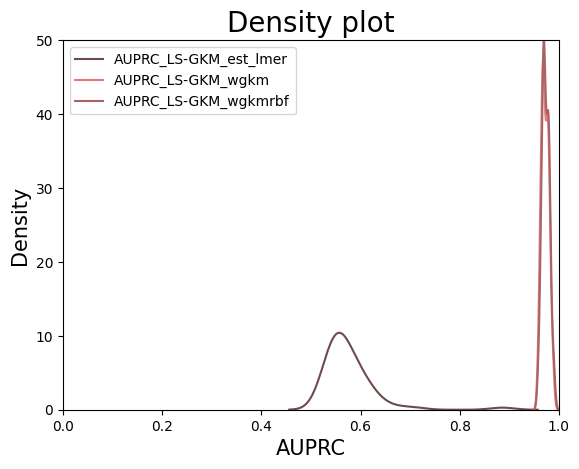

<Figure size 640x480 with 0 Axes>

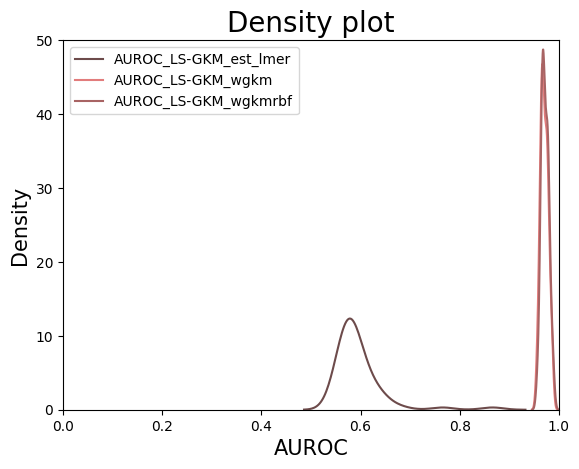

In [268]:
pippo = DensityplotArgs()
densityplot(pippo)